In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
from tqdm.auto import tqdm
import itertools

In [2]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})
commute_data = pd.read_csv('united-states-commutes/commute_data.csv')
census_tracts = pd.read_csv('united-states-commutes/census_tracts_2010.csv')
census_tracts = census_tracts[census_tracts['USPS']=='CA']
commute_data = commute_data[commute_data['OFIPS'].isin(census_tracts['GEOID'].unique())]
commute_data = commute_data[commute_data['DFIPS'].isin(census_tracts['GEOID'].unique())]
census_tracts = census_tracts.sort_values('POP10', ascending=True)
census_tracts.reset_index(inplace=True)
commute_data.reset_index(inplace=True)

From readme:

    - Ofips - the full FIPS code for the origin census tract of an individual flow line
    - Dfips  - the full FIPS code for the destination census tract of an individual flow line
    - Ostfips - the FIPS code for the origin state of an individual flow line
    - Octfips - the FIPS code for the origin county of an individual flow line
    - Otrfips - the FIPS code for the origin census tract of an individual flow line
    - Dstfips - the FIPS code for the destination state of an individual flow line
    - Dctfips - the FIPS code for the destination county of an individual flow line
    - Dtrfips - the FIPS code for the destination census tract of an individual flow line
    - Flow - the total number of commuters associated with this individual point to point flow line (i.e. the total number of journeys to work)
    - Moe - margin of error of the Flow value above
    - LenKM - length of each flow line, in Kilometers
    - ESTDIVMOE - the Flow value divided by the Margin of Error of the estimate 

In [3]:
commute_data.head()

,index,OFIPS,DFIPS,OSTFIPS,OCTFIPS,OTRFIPS,DSTFIPS,DCTFIPS,DTRFIPS,FLOW,MOE,LENKM,ESTDIVMOE
0,0,6073018700,6073018700,6,73,18700,6,73,18700,20950,2359,0.0,8.88
1,4,6071010402,6071010402,6,71,10402,6,71,10402,7040,848,0.0,8.30
2,22,6073009400,6073009400,6,73,9400,6,73,9400,3325,618,0.0,5.38
3,23,6059062614,6059062614,6,59,62614,6,59,62614,3275,1235,0.0,2.65
4,24,6073006300,6073006300,6,73,6300,6,73,6300,3125,755,0.0,4.14


from https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/gaz10-record-layouts.html

    USPS	United States Postal Service State Abbreviation
    GEOID	Geographic Identifier - fully concatenated geographic code (State FIPS and district number)
    POP10	2010 Census population count.
    HU10	2010 Census housing unit count.
    ALAND	Land Area(square meters) - Created for statistical purposes only.
    AWATER	Water Area (square meters) - Created for statistical purposes only.
    ALAND_SQMI	Land Area (square miles) - Created for statistical purposes only.
    AWATER_SQMI	Water Area (square miles) - Created for statistical purposes only.
    INTPTLAT	Latitude (decimal degrees) First character is blank or "-" denoting North or South latitude respectively.
    INTPTLONG	Longitude (decimal degrees) First character is blank or "-" denoting East or West longitude respectively.

In [4]:
census_tracts.head()

,index,USPS,GEOID,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,4212,CA,6015990000,0,0,0,454881798,0.000,175.631,41.751044,-124.249310
1,10483,CA,6083990000,0,0,0,2406070422,0.000,928.989,33.907571,-119.959283
2,7068,CA,6037980025,0,0,2956337,13050,1.141,0.005,33.843375,-118.240029
3,7182,CA,6045990100,0,0,0,869681927,0.000,335.786,39.380294,-123.837729
4,10908,CA,6087990100,0,0,0,388532744,0.000,150.013,36.921793,-122.030507


In [40]:
attribution = np.empty(len(census_tracts))
attribution[:] = np.nan
for index, row in tqdm(census_tracts.iterrows(), total=census_tracts.shape[0]):
            attribution[index] = int(str(row['GEOID'])[:4])
census_tracts['METROP'] = attribution
counties_names = np.unique(attribution)
n_counties = len(counties_names)
pop = np.zeros(n_counties)
for i, ct in enumerate(counties_names):
    pop[i] = census_tracts[census_tracts['METROP'] == ct]['POP10'].sum()
    

groups = {'name' : counties_names,
          'pop' : pop}
california_data = pd.DataFrame.from_dict(groups)




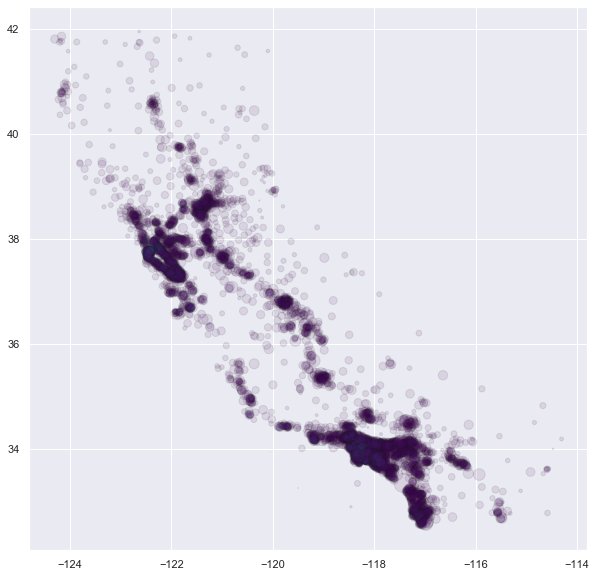

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(census_tracts['INTPTLONG'], census_tracts['INTPTLAT'], s =census_tracts['POP10']/100,
           edgecolors = 'k', c =census_tracts['POP10']/census_tracts['ALAND']*1e5, 
           cmap='viridis', alpha = .1)

Let's seperate the following areas:

    - Bay Area
    - Sacramento
    - Fresno
    - Los Angeles
    - San Diego

In [44]:
groups = {'lat'  : [37.773972,   38.575764,   36.746841,   34.052235,   32.715736],
          'long' : [-122.431297, -121.478851, -119.772591, -118.243683, -117.161087],
          'abbr' : ['SF',        'SC',        'FN',        'LA',        'SD'],
          'name' : ['San Francisco Met. Area',
                    'Sacremento Met. Area',
                    'Fresno  Met. Area',
                    'Los Angeles Met. Area',
                    'San Diego Met. Area'],
          'colors':['r', 'b', 'orange', 'g', 'm'],
          'dist':[120, 50, 100, 100, 50]}
n_group = len(groups['lat'])  # What about San Jose

In [48]:
attribution = np.empty(len(census_tracts))
attribution[:] = np.nan
for index, row in tqdm(census_tracts.iterrows(), total=census_tracts.shape[0]):
    for gr in range(n_group):
        if (geopy.distance.distance((groups['lat'][gr], groups['long'][gr]),
                                   (row['INTPTLAT'],   row['INTPTLONG'])) < groups['dist'][gr]):
            attribution[index] = gr
census_tracts['METROP'] = attribution

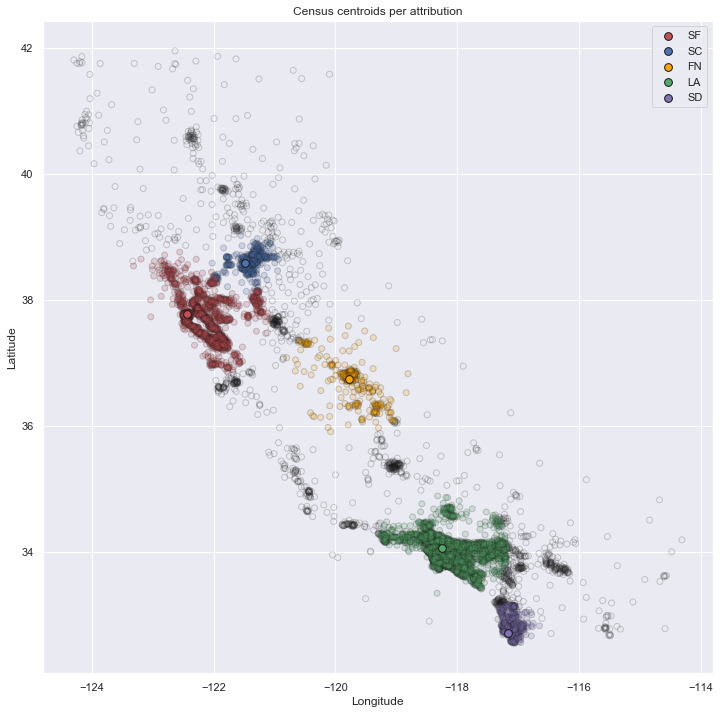

In [8]:
import matplotlib.colors
fig, ax = plt.subplots(1,1, figsize=(12,12))
cmap = matplotlib.colors.ListedColormap(groups['colors'])
boundaries = np.arange(-0.5, n_group, 1)
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)

ax.scatter(census_tracts['INTPTLONG'], census_tracts['INTPTLAT'],
          edgecolors = 'k', c =census_tracts['METROP'], cmap=cmap, norm = norm,
           alpha = .2, plotnonfinite=True)
#ax.scatter(-121.893028, 37.33548,
#          edgecolors = 'k', c ='red')  # San Jose
for gr in range(n_group):
    ax.scatter(groups['long'][gr], groups['lat'][gr], edgecolors = 'k', 
               c =groups['colors'][gr], s = 60, label =groups['abbr'][gr])
ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Census centroids per attribution');

### Let's check which proportion of the population is in our metropolis:


In [103]:
census_tracts[census_tracts['METROP'].isin(np.arange(n_group))]['POP10'].sum()/census_tracts['POP10'].sum()

0.8281765029195826

### Extract and save aggregated node data

In [104]:
pop = np.zeros(n_group)
for gr in range(n_group):
    pop[gr] = census_tracts[census_tracts['METROP'] == gr]['POP10'].sum()

california_data = pd.DataFrame.from_dict(groups)
california_data['pop'] = pop
print(california_data)

         lat        long abbr                     name  colors  dist  \
0  37.773972 -122.431297   SF  San Francisco Met. Area       r   120   
1  38.575764 -121.478851   SC     Sacremento Met. Area       b    50   
2  36.746841 -119.772591   FN        Fresno  Met. Area  orange   100   
3  34.052235 -118.243683   LA    Los Angeles Met. Area       g   100   
4  32.715736 -117.161087   SD      San Diego Met. Area       m    50   

          pop  
0   8005442.0  
1   2095986.0  
2   1770325.0  
3  16353099.0  
4   2627999.0  


In [105]:
california_data.to_csv('california-data/california_data.csv', index_label='id')

### Extract and save mobility data

In [13]:
# Augment commute data with our newly specified metrop:
ori_attr = np.empty(len(commute_data))
dest_attr = np.empty(len(commute_data))
ori_attr[:] = np.nan
dest_attr[:] = np.nan
for index, row in tqdm(commute_data.iterrows(), total=commute_data.shape[0]):
    #if (census_tracts['GEOID'] == row['OFIPS']).any():
    ori_attr[index] =   census_tracts[census_tracts['GEOID'] == row['OFIPS']]['METROP']
    dest_attr[index] = census_tracts[census_tracts['GEOID'] == row['DFIPS']]['METROP']
    #else:
    #    print('{index} not found')

In [16]:
commute_data['OMETROP'] = ori_attr
commute_data['DMETROP'] = dest_attr

In [23]:
commute_data[(commute_data['OMETROP'] == 2) & (commute_data['DMETROP'] == 3)]['FLOW'].sum()

2300

In [24]:
mobility = np.zeros((n_group, n_group))
for ori in range(n_group):
    for dest in range(n_group):
        mobility[ori][dest] = commute_data[(commute_data['OMETROP'] == ori) & (commute_data['DMETROP'] == dest)]['FLOW'].sum()

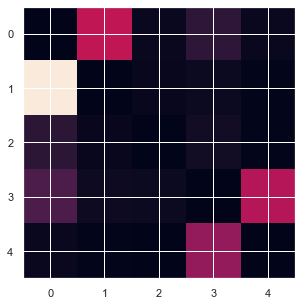

In [28]:
np.fill_diagonal(mobility,0)
plt.imshow(mobility)

In [33]:
np.savetxt('california-data/mobility.txt', mobility)

### Whole pop mobility

In [48]:
# Augment commute data with our newly specified metrop:
ori_attr = np.empty(len(commute_data))
dest_attr = np.empty(len(commute_data))
ori_attr[:] = np.nan
dest_attr[:] = np.nan
for index, row in tqdm(commute_data.iterrows(), total=commute_data.shape[0]):
   
    ori_attr[index] =   census_tracts[census_tracts['GEOID'] == row['OFIPS']]['METROP']
    dest_attr[index] =  census_tracts[census_tracts['GEOID'] == row['DFIPS']]['METROP']

commute_data['OMETROP'] = ori_attr
commute_data['DMETROP'] = dest_attr

In [55]:
mobility = np.zeros((n_counties, n_counties))
for ori_i, ori_v in tqdm(enumerate(counties_names)):
    for dest_i, dest_v in enumerate(counties_names):
        mobility[ori_i][dest_i] = commute_data[(commute_data['OMETROP'] == ori_v) & (commute_data['DMETROP'] == dest_v)]['FLOW'].sum()

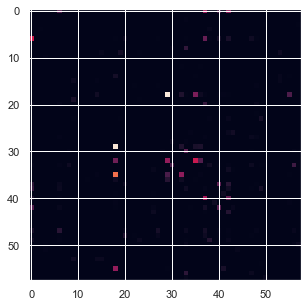

In [56]:
np.fill_diagonal(mobility,0)
plt.imshow(mobility)

In [57]:
np.savetxt('california-data-county/mobility.txt', mobility)

### List of counties to metropolis

In [24]:
(np.round(census_tracts['GEOID']/1e6) == 6001).idxmax()

131

In [27]:
census_tracts['METROP'][3]

nan

In [57]:
counties = pd.read_csv('california-data-county/california_data.csv')

In [83]:
metrop = np.zeros(n_counties)
for i, row in counties.iterrows():
    try:
        metrop[i] = min(census_tracts['METROP'][(np.round(census_tracts['GEOID']/1e6) == int(row['name']))])
    except:  # Attribute SC to SF...
        print('hum')
        metrop[i]  = np.nan

hum
hum


In [86]:
counties['metrop'] = metrop
for i, v in enumerate(groups['abbr']):
    counties['metrop'].replace(i, v, inplace=True)


In [88]:
counties['metrop'].replace(np.nan, 0, inplace=True)

In [91]:
counties.to_csv('california-data-county/california_data.csv', index_label='id')